In [102]:
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Flatten
from keras.utils import to_categorical
import pandas as pd
from datetime import datetime as dt
import talib
import numpy as np

In [103]:
data_df = pd.read_csv('./225537_daily.csv', index_col=[0])

In [104]:
data_df.head()

,open,high,low,close,volume,sma_5,sma_10,ema_20,mtm6_mtm12,fastk,...,roc_10,bband_upper,bband_middle,bband_lower,macd,macdsignal,macdhist,adosc,cci_14,atr_14
date,,,,,,,,,,,,,,,,,,,,,
2008-10-28,449.0,459.0,413.05,421.40,26950.0,447.50,457.475,471.137197,0.909154,0.000000,...,-7.506585,492.770388,447.50,402.229612,-24.489724,-23.933145,-0.556578,186580.861422,-84.887688,42.672054
2008-10-29,430.0,438.5,404.00,416.20,1254388.0,434.70,454.805,465.905083,0.977321,0.000000,...,-6.028449,471.064378,434.70,398.335622,-25.928546,-24.332225,-1.596321,25451.757073,-109.706281,42.088336
2008-10-31,425.0,464.9,419.00,429.90,562630.0,427.56,452.655,462.476028,1.077911,89.362669,...,-4.762960,446.874078,427.56,408.245922,-25.667469,-24.599274,-1.068195,-136773.025365,-45.957285,42.560598
2008-11-03,436.0,436.0,398.15,403.00,853239.0,419.24,448.110,456.811644,1.025402,0.000000,...,-10.134909,437.852082,419.24,400.627918,-27.316284,-25.142676,-2.173608,-392614.143495,-129.301056,42.224126
2008-11-04,407.0,419.0,395.00,401.25,899546.0,414.35,439.765,451.520059,1.086997,0.000000,...,-17.216835,436.174023,414.35,392.525977,-28.436395,-25.801420,-2.634975,-598730.915519,-129.921943,40.922403


In [105]:
#data_df['date'] = data_df['date'].map(lambda x: dt.strptime(x, '%m/%d/%Y %I:%M:%S %p').date())
data_df['volume'] = data_df['volume'].astype(float)
#data_df = data_df.set_index('date')

# Simple Moving Average
data_df['sma_5'] = talib.SMA(data_df['close'].values, timeperiod=5)
data_df['sma_10'] = talib.SMA(data_df['close'].values, timeperiod=10)
# Exponential Moving Average
data_df['ema_20'] = talib.EMA(data_df['close'].values, timeperiod=20)
# Momentum 6 Month / Momentum 12 Month
data_df['mtm6_mtm12'] = talib.MOM(data_df['close'].values, timeperiod=126)/talib.MOM(data_df['close'].values, 
                                  timeperiod=252)
# Stochastic Relative Strength Index
data_df['fastk'], data_df['fastd'] = talib.STOCHRSI(data_df['close'].values, timeperiod=14, fastk_period=5,
                                                    fastd_period=3, fastd_matype=0)
# Rate Of Change
data_df['roc_10'] = talib.ROC(data_df['close'].values, timeperiod=10)
# Bollinger Bands
data_df['bband_upper'], data_df['bband_middle'], data_df['bband_lower'] = talib.BBANDS(data_df['close'].values,
                                                                                     timeperiod=5, nbdevup=2, nbdevdn=2,
                                                                                     matype=0)
# Moving Average Convergence Divergence
data_df['macd'], data_df['macdsignal'], data_df['macdhist'] = talib.MACD(data_df['close'].values, fastperiod=12, 
                                                                         slowperiod=26, signalperiod=9)
# Chaikin A/D Oscillator
data_df['adosc'] = talib.ADOSC(data_df['high'], data_df['low'], data_df['close'], data_df['volume'], fastperiod=3,
                             slowperiod=10)
# Commodity Channel Index
data_df['cci_14'] = talib.CCI(data_df['high'].values, data_df['low'].values, data_df['close'].values, timeperiod=14)
# Average True Range
data_df['atr_14'] = talib.ATR(data_df['high'].values, data_df['low'].values, data_df['close'].values, timeperiod=14)



# Target
data_df['target'] = np.append(data_df['close'][1:].values, [np.nan])
# Drop Rows With NA Values In Any Column
data_df = data_df.dropna(axis=0, how='any')

#### add another column with the class 0 (for downward trajectory) and 1(for positive trajectory)
data_df["prev"] = np.append([np.nan], data_df['close'][:-1],)
data_df = data_df.dropna()
data_df['class'] = np.where((data_df['prev'] < data_df['close']),1,0)

data_df.drop('prev',axis = 1, inplace = True)

# Popping The Target Column
target = data_df.pop('target').values

## Traget classes
target_class = data_df.pop('class').values

In [106]:
target_class

array([0, 1, 0, ..., 1, 0, 1])

In [107]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return(np.array(data), np.array(labels))

In [108]:
TRAIN_SPLIT = round(0.8 * len(data_df))
# Normalizing Data
dataset = data_df.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [109]:
past_history = 21
future_target = 1
STEP = 1
X_train, y_train = multivariate_data(dataset, target_class, 0, TRAIN_SPLIT, past_history, future_target, STEP, 
                                     single_step=True)
X_test, y_test = multivariate_data(dataset, target_class, TRAIN_SPLIT, None, past_history, future_target, STEP, 
                                     single_step=True)
X_train = X_train.reshape(X_train.shape[0],21,21,1)
X_test = X_test.reshape(X_test.shape[0],21,21,1)


In [110]:
y_train.shape

(1944,)

In [111]:
model = Sequential()

In [112]:
model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(21, 21,1)))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size =(2, 2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(units=1, activation='sigmoid'))

In [113]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [114]:
BATCH_SIZE = 32
EPOCHS = 100

model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 1944 samples, validate on 469 samples
Epoch 1/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.7005 - accuracy: 0.5077 - val_loss: 0.6927 - val_accuracy: 0.5437
Epoch 2/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.6922 - accuracy: 0.5237 - val_loss: 0.6933 - val_accuracy: 0.5053
Epoch 3/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.6873 - accuracy: 0.5478 - val_loss: 0.7060 - val_accuracy: 0.5203
Epoch 4/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.6777 - accuracy: 0.5643 - val_loss: 0.7133 - val_accuracy: 0.5416
Epoch 5/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.6632 - accuracy: 0.6060 - val_loss: 0.7191 - val_accuracy: 0.5203
Epoch 6/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.6428 - accuracy: 0.6250 - val_loss: 0.7307 - val_accuracy: 0.5224
Epoch 7/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.6126

KeyboardInterrupt: 

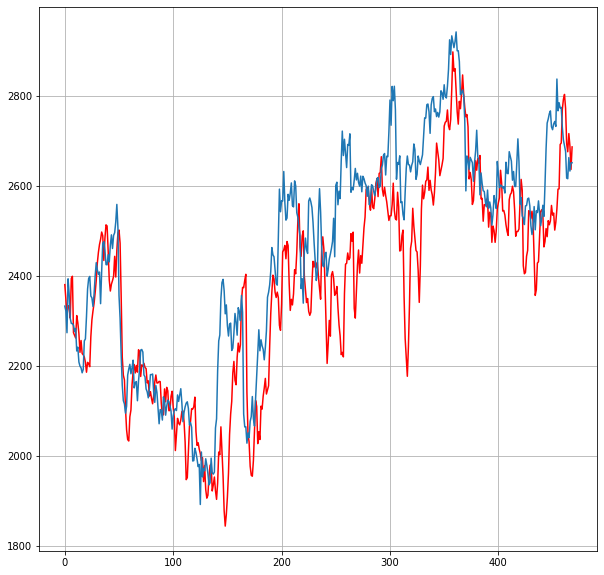

In [233]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(model.predict(X_test), color = 'r')
plt.grid()
plt.plot(y_test)

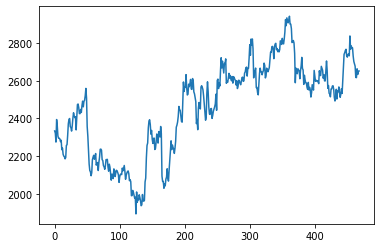

In [229]:
plt.plot(y_test)

In [172]:
X_test = X_test.reshape(X_test.shape[0],21,21,1).shape

In [309]:
data_df["temp"] = np.append([np.nan], data_df['close'][:-1],)
data_df = data_df.dropna()

In [316]:
data_df['close']

date
2009-11-16    1102.35
2009-11-17    1110.75
2009-11-18    1107.65
2009-11-19    1098.90
2009-11-20    1117.55
               ...   
2019-10-04    2617.70
2019-10-07    2616.45
2019-10-09    2663.40
2019-10-10    2633.50
2019-10-11    2651.40
Name: close, Length: 2456, dtype: float64

In [317]:
data_df['temp']

date
2009-11-16    1108.65
2009-11-17    1102.35
2009-11-18    1110.75
2009-11-19    1107.65
2009-11-20    1098.90
               ...   
2019-10-04    2677.15
2019-10-07    2617.70
2019-10-09    2616.45
2019-10-10    2663.40
2019-10-11    2633.50
Name: temp, Length: 2456, dtype: float64

In [274]:
data_df["target"] = target

In [275]:
data_df["target"]

date
2009-11-13    1102.35
2009-11-16    1110.75
2009-11-17    1107.65
2009-11-18    1098.90
2009-11-19    1117.55
               ...   
2019-10-04    2616.45
2019-10-07    2663.40
2019-10-09    2633.50
2019-10-10    2651.40
2019-10-11    2651.90
Name: target, Length: 2457, dtype: float64

In [278]:
# for x,y in data_df["close"],data_df["temp"]:
#     if x < y : 
#         data_df["class"] = 1
#     else :
#         data_df['class'] = 

# if data_df["close"] < data_df["temp"]:
#     data["class"] = 1
# else : 
#     data["class"] = 0
    
data_df['class'] = [1 if x < y else 0 for x,y in data_df['close'], data_df['target']]

SyntaxError: invalid syntax (<ipython-input-278-47478b1d80d4>, line 12)

In [282]:
data_df['class']

date
2009-11-13    0
2009-11-16    1
2009-11-17    0
2009-11-18    0
2009-11-19    1
             ..
2019-10-04    0
2019-10-07    1
2019-10-09    0
2019-10-10    1
2019-10-11    1
Name: class, Length: 2457, dtype: int64

In [284]:
data_df['close']

date
2009-11-13    1108.65
2009-11-16    1102.35
2009-11-17    1110.75
2009-11-18    1107.65
2009-11-19    1098.90
               ...   
2019-10-04    2617.70
2019-10-07    2616.45
2019-10-09    2663.40
2019-10-10    2633.50
2019-10-11    2651.40
Name: close, Length: 2457, dtype: float64

In [285]:
target

array([1102.35, 1110.75, 1107.65, ..., 2633.5 , 2651.4 , 2651.9 ])

In [288]:
data_df.head()

,open,high,low,close,volume,sma_5,sma_10,ema_20,mtm6_mtm12,fastk,...,bband_middle,bband_lower,macd,macdsignal,macdhist,adosc,cci_14,atr_14,target,class
date,,,,,,,,,,,,,,,,,,,,,
2009-11-13,1107.00,1120.95,1096.00,1108.65,162748.0,1107.48,1078.780,1037.040428,0.758821,0.000000,...,1107.48,1082.445176,51.542123,44.986421,6.555701,82120.478264,85.592224,41.284589,1102.35,0
2009-11-16,1110.00,1124.60,1080.50,1102.35,711035.0,1107.98,1087.875,1043.260388,0.770677,0.000000,...,1107.98,1083.480563,50.400971,46.069331,4.331640,66997.143935,68.922981,41.485690,1110.75,1
2009-11-17,1109.90,1119.80,1095.05,1110.75,511877.0,1111.88,1095.500,1049.687970,0.731145,14.514965,...,1111.88,1093.946612,49.602622,46.775989,2.826632,98480.693987,71.206147,40.290283,1107.65,0
2009-11-18,1110.75,1124.90,1103.05,1107.65,319970.0,1107.63,1099.815,1055.208163,0.731853,5.884116,...,1107.63,1101.979655,48.164569,47.053705,1.110863,43465.695631,69.428519,38.973120,1098.90,0
2009-11-19,1106.00,1107.65,1082.30,1098.90,365055.0,1105.66,1102.630,1059.369290,0.671755,0.000000,...,1105.66,1096.921030,45.790999,46.801164,-1.010165,52976.883737,26.546429,38.000040,1117.55,1


In [11]:
data_df["prev"] = np.append([np.nan], data_df['close'][:-1],)
data_df = data_df.dropna()
data_df['class'] = np.where((data_df['prev'] < data_df['close']),1,0)

data_df.drop('prev',axis = 1, inplace = True)



/Users/tushar/.local/share/virtualenvs/jupyter-JBaKRCeA/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tushar/.local/share/virtualenvs/jupyter-JBaKRCeA/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
data_df['class']

date
2009-11-17    1
2009-11-18    0
2009-11-19    0
2009-11-20    1
2009-11-23    0
             ..
2019-10-04    0
2019-10-07    0
2019-10-09    1
2019-10-10    0
2019-10-11    1
Name: class, Length: 2455, dtype: int64

In [29]:
target_class.shape

(2456,)

In [115]:
data_df.head()

,open,high,low,close,volume,sma_5,sma_10,ema_20,mtm6_mtm12,fastk,...,roc_10,bband_upper,bband_middle,bband_lower,macd,macdsignal,macdhist,adosc,cci_14,atr_14
date,,,,,,,,,,,,,,,,,,,,,
2009-11-16,1110.00,1124.60,1080.50,1102.35,711035.0,1107.98,1087.875,1043.260388,0.770677,0.000000,...,8.992486,1132.479437,1107.98,1083.480563,50.400971,46.069331,4.331640,66997.143935,68.922981,41.485690
2009-11-17,1109.90,1119.80,1095.05,1110.75,511877.0,1111.88,1095.500,1049.687970,0.731145,14.514965,...,7.370710,1129.813388,1111.88,1093.946612,49.602622,46.775989,2.826632,98480.693987,71.206147,40.290283
2009-11-18,1110.75,1124.90,1103.05,1107.65,319970.0,1107.63,1099.815,1055.208163,0.731853,5.884116,...,4.053546,1113.280345,1107.63,1101.979655,48.164569,47.053705,1.110863,43465.695631,69.428519,38.973120
2009-11-19,1106.00,1107.65,1082.30,1098.90,365055.0,1105.66,1102.630,1059.369290,0.671755,0.000000,...,2.628998,1114.398970,1105.66,1096.921030,45.790999,46.801164,-1.010165,52976.883737,26.546429,38.000040
2009-11-20,1095.00,1126.00,1083.20,1117.55,957466.0,1107.44,1107.460,1064.910310,0.674406,74.816469,...,4.517185,1120.464654,1107.44,1094.415346,44.897280,46.420387,-1.523107,236406.656688,57.784525,38.342895
